<a href="https://colab.research.google.com/github/AlessiaLombarda/UrbanSoundClassification/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup and utils

In [ ]:
!pip install librosa

In [9]:
import os
import csv
import librosa
import numpy as np
import pandas as pd
import librosa.display
import tensorflow as tf
from pathlib import Path
import scipy.stats as scp
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
from sklearn.preprocessing import MinMaxScaler

In [17]:
from tensorflow.keras import layers
from tensorflow.keras import models

Function to delete a given dataset


In [29]:
def delete_ds(path):
  for dir in os.listdir(path):
    if(dir!='.DS_Store'):
      for file in os.listdir(path+"/"+dir+"/"):
        if(file!='.DS_Store'):
          os.remove(path+"/"+dir+"/"+file)
      os.rmdir(path+"/"+dir)

  os.rmdir(path)

##Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/statistics.csv /content/statistics.csv
drive.flush_and_unmount()

In [ ]:
drive.mount('/content/drive')
!tar -xf /content/drive/MyDrive/UrbanSoundPreprocessed.tar.gz
drive.flush_and_unmount()
!cp -r /content/content/UrbanSoundPreprocessed /content/UrbanSoundPreprocessed
delete_ds("/content/content/UrbanSoundPreprocessed/")
os.rmdir("/content/content/")

In [30]:
delete_ds("/content/content/UrbanSoundPreprocessed/")
os.rmdir("/content/content/")

In [13]:
data = pd.read_csv('/content/statistics.csv')
data.head()

,filename,min,max,median,mean,var,rms,energy_min,energy_max,energy_median,...,chroma11_median,chroma11_mean,chroma11_var,chroma12_min,chroma12_max,chroma12_median,chroma12_mean,chroma12_var,fold,class
0,155242-9-0-44.wav,-0.641214,0.677659,-0.000127,-0.000222,0.011993,493.407560,0.022887,0.219585,0.090520,...,0.611251,0.639246,0.088220,0.047971,1.0,0.361837,0.379732,0.045425,9,9
1,60935-2-0-0.wav,-0.057131,0.069105,0.000000,-0.000014,0.000089,699.353800,0.001015,0.035245,0.003274,...,0.238961,0.319140,0.079946,0.004396,1.0,0.294113,0.380026,0.102235,9,2
2,58937-4-0-12.wav,-0.580689,0.524841,0.001114,-0.000209,0.008145,431.849270,0.023346,0.159962,0.083212,...,0.528279,0.536120,0.036420,0.180515,1.0,0.540637,0.558196,0.037676,9,4
3,39856-5-0-11.wav,-1.000000,0.999969,0.000000,-0.003131,0.170600,131.920930,0.120246,0.516182,0.414045,...,0.486282,0.506858,0.074786,0.064597,1.0,0.494290,0.520847,0.064415,9,5
4,79089-0-0-73.wav,-0.688963,0.915431,-0.000276,-0.001193,0.008306,76.422585,0.025862,0.248881,0.049012,...,0.445517,0.440587,0.048172,0.029658,1.0,0.609756,0.607751,0.079218,9,0


Distribution of samples for each category in train and test folds

In [ ]:
stats = pd.read_csv("/content/statistics.csv")
stats[(stats['fold']==1)|(stats['fold']==2)|(stats['fold']==3)|(stats['fold']==4)|(stats['fold']==6)]['class'].value_counts().sort_index()

0    500
1    208
2    500
3    500
4    500
5    517
6    190
7    548
8    536
9    500
Name: class, dtype: int64

In [ ]:
stats = pd.read_csv("/content/statistics.csv")
stats[(stats['fold']==5)|(stats['fold']==7)|(stats['fold']==8)|(stats['fold']==9)|(stats['fold']==10)]['class'].value_counts().sort_index()

0    500
1    221
2    500
3    500
4    500
5    483
6    184
7    452
8    393
9    500
Name: class, dtype: int64

##Models

In this section the functions to create models' architectures are defined

In [18]:
def create_raw_model(input_shape):
  model = models.Sequential()
  model.add(layers.Conv1D(filters=64, kernel_size=5, input_shape=input_shape, activation='relu')) 
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv1D(filters=128, kernel_size=4, activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv1D(filters=256, kernel_size=3, activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv1D(filters=512, kernel_size=2, activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Dropout(0.2))

  model.add(layers.GlobalAveragePooling1D())

  model.add(layers.Dense(10, activation='softmax'))
  
  return model

In [19]:
def create_base_model(input_shape):
  model = models.Sequential()
  model.add(layers.Dense(1024, input_shape = input_shape, activation = 'relu')),
  model.add(layers.Dense(512, activation = 'relu')),
  model.add(layers.Dense(10, activation='softmax'))

  return model

In [20]:
def create_adv1_model(input_shape):
  model = models.Sequential()
  model.add(layers.Dense(1024, input_shape = input_shape, activation = 'relu')),
  model.add(layers.Dense(512, activation = 'relu')),
  model.add(layers.Dense(10, activation='softmax'))

  return model

In [21]:
def create_adv2_model(input_shape):
  model = models.Sequential()
  model.add(layers.Dense(64, input_shape = input_shape, activation = 'relu')),
  model.add(layers.Dense(64, activation = 'relu')),
  model.add(layers.Dense(32, activation = 'relu')),
  model.add(layers.Dense(16, activation = 'relu')),
  model.add(layers.Dense(10, activation='softmax'))

  return model

In [22]:
def create_pca_model(input_shape):
  model = models.Sequential()
  model.add(layers.Dense(64, input_shape = input_shape, activation = 'relu')),
  model.add(layers.Dense(32, activation = 'relu')),
  model.add(layers.Dense(10, activation='softmax'))

  return model

In [23]:
def create_mel_model(input_shape):
  model = models.Sequential()
  model.add(layers.Conv2D(filters=16, kernel_size=5, input_shape=input_shape, activation='relu')) 
  model.add(layers.MaxPooling2D(pool_size=2))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(filters=32, kernel_size=4, activation='relu'))  
  model.add(layers.MaxPooling2D(pool_size=2))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(filters=64, kernel_size=2, activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=2))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(filters=128, kernel_size=2, activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=2))
  model.add(layers.Dropout(0.2))

  model.add(layers.GlobalAveragePooling2D())

  model.add(layers.Dense(10, activation='softmax'))
  
  return model

In [24]:
def create_mfcc_model(input_shape):
  model = models.Sequential()
  model.add(layers.Conv2D(filters=16, kernel_size=5, input_shape=input_shape, activation='relu')) 
  model.add(layers.MaxPooling2D(pool_size=2))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(filters=32, kernel_size=4, activation='relu'))  
  model.add(layers.MaxPooling2D(pool_size=2))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(filters=64, kernel_size=2, activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=2))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(filters=128, kernel_size=2, activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=2))
  model.add(layers.Dropout(0.2))

  model.add(layers.GlobalAveragePooling2D())

  model.add(layers.Dense(10, activation='softmax'))
  
  return model

In [25]:
def create_chroma_model(input_shape):
  model = models.Sequential()
  model.add(layers.Conv2D(filters=128, kernel_size=2, input_shape=input_shape, activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=2))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(filters=256, kernel_size=2, activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=2))
  model.add(layers.Dropout(0.2))

  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dense(10, activation='softmax'))
  
  return model

##Raw data

In [ ]:
raw_x_train = []
raw_y_train = []

for dir in os.listdir("/content/UrbanSoundPreprocessed"):
    for file in os.listdir("/content/UrbanSoundPreprocessed/"+dir+"/"):
      if ((dir == 'fold1') | (dir == 'fold2') | (dir == 'fold3') | (dir == 'fold4') | (dir == 'fold6')):
        file_path = "./UrbanSoundPreprocessed/"+dir+"/"+file
        sound_file, sampling_rate = librosa.load(file_path, sr = 22050)
        raw_x_train.append(sound_file)
        raw_y_train.append(data['class'][data['filename']==file].item())

In [ ]:
rx = np.array(raw_x_train)
ry = np.array(raw_y_train)
del raw_x_train
del raw_y_train

In [ ]:
rx = rx.reshape(rx.shape[0], rx.shape[1], 1)
input_shape = rx.shape[1:]
print(input_shape)

(89009, 1)


In [ ]:
#model structure 
raw_model = create_raw_model(input_shape)

In [ ]:
#model compilation and setup
raw_model.compile(optimizer = 'adam',
  loss = tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics = ['accuracy']
)

In [ ]:
#training
EPOCHS = 100
BATCH_SIZE = 16
raw_model.fit(rx, ry, epochs=EPOCHS, batch_size=BATCH_SIZE)

In [ ]:
del rx
del ry
print(raw_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 89005, 64)         384       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 44502, 64)        0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 44502, 64)         0         
                                                                 
 conv1d_5 (Conv1D)           (None, 44499, 128)        32896     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 22249, 128)       0         
 1D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 22249, 128)       

In [ ]:
raw_x_test = []
raw_y_test = []

for dir in os.listdir("/content/UrbanSoundPreprocessed"):
    for file in os.listdir("/content/UrbanSoundPreprocessed/"+dir+"/"):
      if ((dir == 'fold5') | (dir == 'fold7') | (dir == 'fold8') | (dir == 'fold9') | (dir == 'fold10')):
        file_path = "./UrbanSoundPreprocessed/"+dir+"/"+file
        sound_file, sampling_rate = librosa.load(file_path, sr = 22050)
        raw_x_test.append(sound_file)
        raw_y_test.append(data['class'][data['filename']==file].item())

In [ ]:
rxt = np.array(raw_x_test)
del raw_x_test
ryt = np.array(raw_y_test)
del raw_y_test

In [ ]:
#testing
test_loss, test_acc = raw_model.evaluate(rxt, ryt, verbose = 1)
print(test_acc)

133/133 [==============================] - 37s 272ms/step - loss: 5.7546 - accuracy: 0.4843
0.48429009318351746


In [ ]:
y_pred = np.argmax(raw_model.predict(rxt), axis=1)
y_pred_2 = np.argsort(raw_model.predict(rxt), axis=1)[:,-2]
y_true = ryt

test_acc = (sum(y_pred == y_true) + sum(y_pred_2 == y_true))/ len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 65%


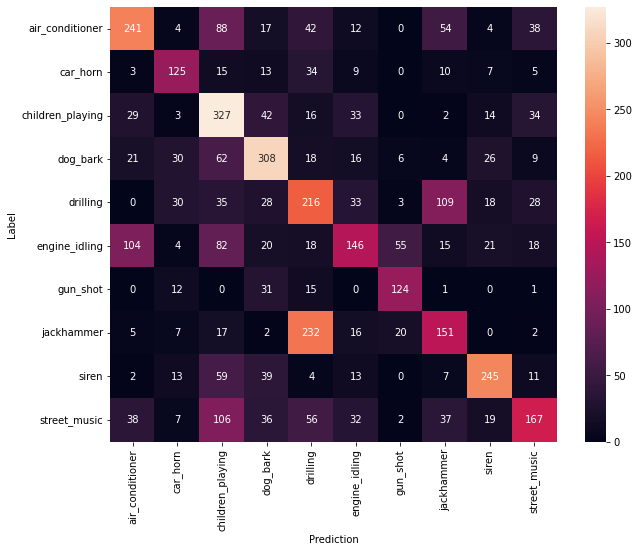

In [ ]:
import seaborn as sns
categories = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=categories,
            yticklabels=categories,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

##Base statistics


In [ ]:
scaler = MinMaxScaler()
rescaled_x = scaler.fit_transform(data[['min', 'max', 'median', 'mean', 'var', 'rms',
                                    'energy_min', 'energy_max', 'energy_median', 'energy_mean', 'energy_var', 
                                    'zcr_min', 'zcr_max', 'zcr_median', 'zcr_mean', 'zcr_var',
                                    'cent_min', 'cent_max', 'cent_median', 'cent_mean', 'cent_var',
                                    'bw_min', 'bw_max', 'bw_median', 'bw_mean', 'bw_var', 
                                    'rolloff_min', 'rolloff_max', 'rolloff_median', 'rolloff_mean', 'rolloff_var',
                                    'flatness_min', 'flatness_max', 'flatness_median', 'flatness_mean', 'flatness_var']])
labels = data['class'] 
folds = data['fold']

base_x_train = rescaled_x[folds[(folds == 1) |(folds == 2) |(folds == 3) |(folds == 4) |(folds == 6)].index]
base_y_train = labels[folds[(folds == 1) |(folds == 2) |(folds == 3) |(folds == 4) |(folds == 6)].index]
base_y_train = np.array(base_y_train)
base_x_test = rescaled_x[folds[(folds == 5) |(folds == 7) |(folds == 8) |(folds == 9) |(folds == 10)].index]
base_y_test = labels[folds[(folds == 5) |(folds == 7) |(folds == 8) |(folds == 9) |(folds == 10)].index]
base_y_test = np.array(base_y_test)

base_x_test_5 = rescaled_x[folds[(folds == 5)].index]
base_x_test_7 = rescaled_x[folds[(folds == 7)].index]
base_x_test_8 = rescaled_x[folds[(folds == 8)].index]
base_x_test_9 = rescaled_x[folds[(folds == 9)].index]
base_x_test_10 = rescaled_x[folds[(folds == 10)].index]
base_y_test_5 = labels[folds[(folds == 5)].index]
base_y_test_7 = labels[folds[(folds == 7)].index]
base_y_test_8 = labels[folds[(folds == 8)].index]
base_y_test_9 = labels[folds[(folds == 9)].index]
base_y_test_10 = labels[folds[(folds == 10)].index]


In [ ]:
input_shape = base_x_train.shape[1:]
base_model = create_base_model(input_shape)

In [ ]:
#model compilation and setup
base_model.compile(optimizer = 'adam',
  loss = tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics = ['accuracy']
)

In [ ]:
base_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 1014)              38532     
                                                                 
 dense_46 (Dense)            (None, 512)               519680    
                                                                 
 dense_47 (Dense)            (None, 10)                5130      
                                                                 
Total params: 563,342
Trainable params: 563,342
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#training
EPOCHS = 30
BATCH_SIZE = 32
base_model.fit(base_x_train, 
               base_y_train, 
               epochs = EPOCHS, 
               batch_size=BATCH_SIZE)

In [ ]:
# Evaluating the model on the training and testing set
test_loss, test_acc = base_model.evaluate(base_x_test, base_y_test, verbose = 1)

test_loss_5, test_acc_5 = base_model.evaluate(base_x_test_5, base_y_test_5, verbose = 1)

test_loss_7, test_acc_7 = base_model.evaluate(base_x_test_7, base_y_test_7, verbose = 1)

test_loss_8, test_acc_8 = base_model.evaluate(base_x_test_8, base_y_test_8, verbose = 1)

test_loss_9, test_acc_9 = base_model.evaluate(base_x_test_9, base_y_test_9, verbose = 1)

test_loss_10, test_acc_10 = base_model.evaluate(base_x_test_10, base_y_test_10, verbose = 1)

average_accuracy = sum([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10])/5
accuracy_std = np.std(np.array([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10]))

print("Test Accuracy:" + str(average_accuracy))
print("Accuracy Std:" + str(accuracy_std))

27/27 [==============================] - 0s 4ms/step - loss: 2.1728 - accuracy: 0.5066
Test Accuracy:0.48657960891723634
Accuracy Std:0.021368930282713795


In [ ]:
y_pred = np.argmax(base_model.predict(base_x_test), axis=1)
y_pred_2 = np.argsort(base_model.predict(base_x_test), axis=1)[:,-2]
y_true = base_y_test

test_acc = (sum(y_pred == y_true) + sum(y_pred_2 == y_true))/ len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 71%


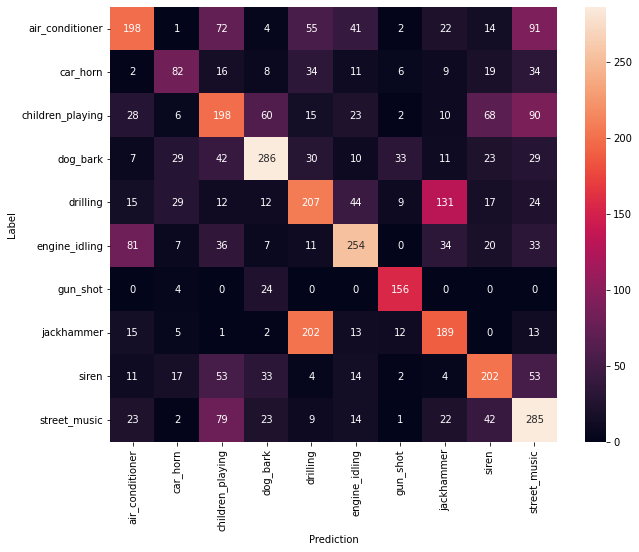

In [ ]:
import seaborn as sns
categories = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=categories,
            yticklabels=categories,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

###Overall testing

In [ ]:
result= []
for BATCH_SIZE in [32,64,128]:  
  for EPOCHS in [30,40,50,70]:
    for i in range(3):
      base_model = create_base_model(input_shape) 
      
      base_model.compile(
          loss='sparse_categorical_crossentropy', 
          metrics=['accuracy'], 
          optimizer='adam'
      )
      
      history = base_model.fit(
          base_x_train, 
          base_y_train, 
          epochs=EPOCHS,
          batch_size = BATCH_SIZE
      )

      test_loss, test_acc = base_model.evaluate(base_x_test, base_y_test, verbose = 1)

      test_loss_5, test_acc_5 = base_model.evaluate(base_x_test_5, base_y_test_5, verbose = 1)

      test_loss_7, test_acc_7 = base_model.evaluate(base_x_test_7, base_y_test_7, verbose = 1)

      test_loss_8, test_acc_8 = base_model.evaluate(base_x_test_8, base_y_test_8, verbose = 1)

      test_loss_9, test_acc_9 = base_model.evaluate(base_x_test_9, base_y_test_9, verbose = 1)

      test_loss_10, test_acc_10 = base_model.evaluate(base_x_test_10, base_y_test_10, verbose = 1)

      average_accuracy = sum([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10])/5
      accuracy_std = np.std(np.array([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10]))

      result.append("Batch size:\t\t"+ str(BATCH_SIZE) + "\t\t Epoche:\t\t"+ str(EPOCHS) + "\t\t Train acc:\t\t"+ str(history.history['accuracy'][-1])+ "\t\t Test acc:\t\t"+ str(average_accuracy) + "\t\t Test accuracy Std:\t\t" + str(accuracy_std))

In [ ]:
f=open('base_results.txt','w')
for ele in result:
    f.write(ele+'\n')

In [ ]:
f.close()
from google.colab import files
files.download('base_results.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Advanced statistics

In [14]:
scaler = MinMaxScaler()
rescaled_x = scaler.fit_transform(data.iloc[:,1:-2])
labels = data['class'] 
folds = data['fold']

adv_x_train = rescaled_x[folds[(folds == 1) |(folds == 2) |(folds == 3) |(folds == 4) |(folds == 6)].index]
adv_y_train = labels[folds[(folds == 1) |(folds == 2) |(folds == 3) |(folds == 4) |(folds == 6)].index]
adv_y_train = np.array(adv_y_train)
adv_x_test = rescaled_x[folds[(folds == 5) |(folds == 7) |(folds == 8) |(folds == 9) |(folds == 10)].index]
adv_y_test = labels[folds[(folds == 5) |(folds == 7) |(folds == 8) |(folds == 9) |(folds == 10)].index]
adv_y_test = np.array(adv_y_test)

adv_x_test_5 = rescaled_x[folds[(folds == 5)].index]
adv_x_test_7 = rescaled_x[folds[(folds == 7)].index]
adv_x_test_8 = rescaled_x[folds[(folds == 8)].index]
adv_x_test_9 = rescaled_x[folds[(folds == 9)].index]
adv_x_test_10 = rescaled_x[folds[(folds == 10)].index]
adv_y_test_5 = labels[folds[(folds == 5)].index]
adv_y_test_7 = labels[folds[(folds == 7)].index]
adv_y_test_8 = labels[folds[(folds == 8)].index]
adv_y_test_9 = labels[folds[(folds == 9)].index]
adv_y_test_10 = labels[folds[(folds == 10)].index]

In [26]:
input_shape = adv_x_train.shape[1:]
adv_model = create_adv1_model(input_shape)

In [ ]:
#model compilation and setup
adv_model.compile(optimizer = 'adam',
  loss = tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics = ['accuracy']
)

In [27]:
adv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              380928    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 910,858
Trainable params: 910,858
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#training
EPOCHS = 30
BATCH_SIZE = 32
adv_model.fit(adv_x_train, 
               adv_y_train, 
               epochs = EPOCHS, 
               batch_size=BATCH_SIZE)

In [ ]:
# Evaluating the model on the training and testing set
test_loss, test_acc = adv_model.evaluate(adv_x_test, adv_y_test, verbose = 1)

test_loss_5, test_acc_5 = adv_model.evaluate(adv_x_test_5, adv_y_test_5, verbose = 1)

test_loss_7, test_acc_7 = adv_model.evaluate(adv_x_test_7, adv_y_test_7, verbose = 1)

test_loss_8, test_acc_8 = adv_model.evaluate(adv_x_test_8, adv_y_test_8, verbose = 1)

test_loss_9, test_acc_9 = adv_model.evaluate(adv_x_test_9, adv_y_test_9, verbose = 1)

test_loss_10, test_acc_10 = adv_model.evaluate(adv_x_test_10, adv_y_test_10, verbose = 1)

average_accuracy = sum([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10])/5
accuracy_std = np.std(np.array([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10]))

print("Test Accuracy:" + str(average_accuracy))
print("Accuracy Std:" + str(accuracy_std))

In [ ]:
y_pred = np.argmax(adv_model.predict(adv_x_test), axis=1)
y_pred_2 = np.argsort(adv_model.predict(adv_x_test), axis=1)[:,-2]
y_true = adv_y_test

test_acc = (sum(y_pred == y_true) + sum(y_pred_2 == y_true))/ len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

In [ ]:
import seaborn as sns
categories = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=categories,
            yticklabels=categories,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

###Overall testing

In [ ]:
result= []
for BATCH_SIZE in [32,64,128]:  
  for EPOCHS in [30,40,50,70]:
    for i in range(3):
      adv_model = create_adv1_model(input_shape) 
      
      adv_model.compile(
          loss='sparse_categorical_crossentropy', 
          metrics=['accuracy'], 
          optimizer='adam'
      )
      
      history = adv_model.fit(
          base_x_train, 
          base_y_train, 
          epochs=EPOCHS,
          batch_size = BATCH_SIZE
      )

      test_loss, test_acc = adv_model.evaluate(adv_x_test, adv_y_test, verbose = 1)

      test_loss_5, test_acc_5 = adv_model.evaluate(adv_x_test_5, adv_y_test_5, verbose = 1)

      test_loss_7, test_acc_7 = adv_model.evaluate(adv_x_test_7, adv_y_test_7, verbose = 1)

      test_loss_8, test_acc_8 = adv_model.evaluate(adv_x_test_8, adv_y_test_8, verbose = 1)

      test_loss_9, test_acc_9 = adv_model.evaluate(adv_x_test_9, adv_y_test_9, verbose = 1)

      test_loss_10, test_acc_10 = adv_model.evaluate(adv_x_test_10, adv_y_test_10, verbose = 1)

      average_accuracy = sum([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10])/5
      accuracy_std = np.std(np.array([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10]))

      result.append("Batch size:\t\t"+ str(BATCH_SIZE) + "\t\t Epoche:\t\t"+ str(EPOCHS) + "\t\t Train acc:\t\t"+ str(history.history['accuracy'][-1])+ "\t\t Test acc:\t\t"+ str(average_accuracy) + "\t\t Test accuracy Std:\t\t" + str(accuracy_std))

In [ ]:
f=open('base_results.txt','w')
for ele in result:
    f.write(ele+'\n')

In [ ]:
f.close()
from google.colab import files
files.download('base_results.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##MLP on PCA features

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
rescaled_x = scaler.fit_transform(data.iloc[:,1:-2])
labels = data['class'] 
folds = data['fold']

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.98)
statistics_pca = pca.fit_transform(rescaled_x)

#print(pca.explained_variance_ratio_)
#print(statistics_pca)
#print(statistics_pca.shape)

In [ ]:
pca_x_train = statistics_pca[folds[(folds == 1) |(folds == 2) |(folds == 3) |(folds == 4) |(folds == 6)].index]
pca_y_train = labels[folds[(folds == 1) |(folds == 2) |(folds == 3) |(folds == 4) |(folds == 6)].index]
pca_y_train = np.array(pca_y_train)

In [ ]:
pca_x_test = statistics_pca[folds[(folds == 5) |(folds == 7) |(folds == 8) |(folds == 9) |(folds == 10)].index]
pca_y_test = labels[folds[(folds == 5) |(folds == 7) |(folds == 8) |(folds == 9) |(folds == 10)].index]
pca_y_test = np.array(pca_y_test)

pca_x_test_5 = statistics_pca[folds[(folds == 5)].index] 
pca_y_test_5 = labels[folds[(folds == 5)].index]
pca_y_test_5 = np.array(pca_y_test_5)

pca_x_test_7 = statistics_pca[folds[(folds == 7)].index] 
pca_y_test_7 = labels[folds[(folds == 7)].index]
pca_y_test_7 = np.array(pca_y_test_7)

pca_x_test_8 = statistics_pca[folds[(folds == 8)].index] 
pca_y_test_8 = labels[folds[(folds == 8)].index]
pca_y_test_8 = np.array(pca_y_test_8)

pca_x_test_9 = statistics_pca[folds[(folds == 9)].index] 
pca_y_test_9 = labels[folds[(folds == 9)].index]
pca_y_test_9 = np.array(pca_y_test_9)

pca_x_test_10 = statistics_pca[folds[(folds == 10)].index] 
pca_y_test_10 = labels[folds[(folds == 10)].index]
pca_y_test_10 = np.array(pca_y_test_10)

In [ ]:
input_shape = pca_x_train.shape[1:]
print(input_shape)

(97,)


In [ ]:
pca_model = create_pca_model(input_shape)

In [ ]:
pca_model.compile(optimizer = 'adam',
  loss = tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics = ['accuracy']
)

In [ ]:
pca_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                6272      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 8,682
Trainable params: 8,682
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#training
EPOCHS = 30
BATCH_SIZE = 32
pca_model.fit(pca_x_train, pca_y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

In [ ]:
#testing
test_loss, test_acc = pca_model.evaluate(pca_x_test, pca_y_test, verbose = 1)
test_loss_5, test_acc_5 = pca_model.evaluate(pca_x_test_5, pca_y_test_5, verbose = 1)

test_loss_7, test_acc_7 = pca_model.evaluate(pca_x_test_7, pca_y_test_7, verbose = 1)

test_loss_8, test_acc_8 = pca_model.evaluate(pca_x_test_8, pca_y_test_8, verbose = 1)

test_loss_9, test_acc_9 = pca_model.evaluate(pca_x_test_9, pca_y_test_9, verbose = 1)

test_loss_10, test_acc_10 = pca_model.evaluate(pca_x_test_10, pca_y_test_10, verbose = 1)

average_accuracy = sum([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10])/5
accuracy_std = np.std(np.array([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10]))

print("Test Accuracy:" + str(average_accuracy))
print("Accuracy Std:" + str(accuracy_std))

27/27 [==============================] - 0s 5ms/step - loss: 1.7976 - accuracy: 0.5615
Test Accuracy:0.5530329823493958
Accuracy Std:0.029657698180613073


In [ ]:
y_pred = np.argmax(pca_model.predict(pca_x_test), axis=1)
y_pred_2 = np.argsort(pca_model.predict(pca_x_test), axis=1)[:,-2]
y_true = pca_y_test

test_acc = (sum(y_pred == y_true) + sum(y_pred_2 == y_true))/ len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 73%


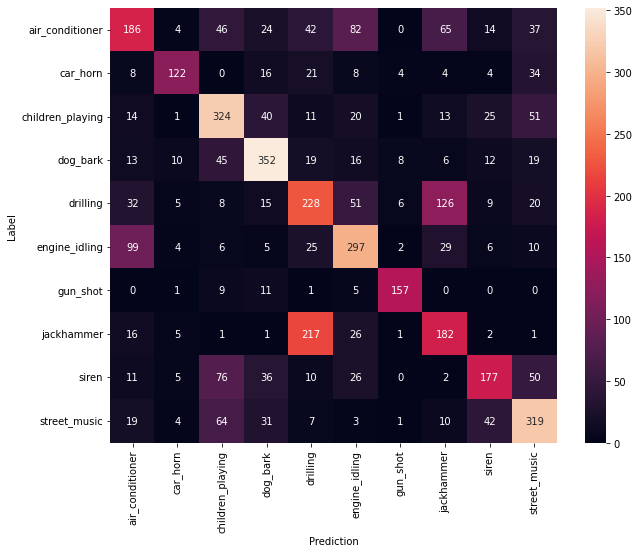

In [ ]:
import seaborn as sns
categories = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=categories,
            yticklabels=categories,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

###Overall testing

In [ ]:
result= []
for pca_variance in [0.90,0.95,0.98,0.99]:
  scaler = MinMaxScaler()
  rescaled_x = scaler.fit_transform(data.iloc[:,1:-2])
  labels = data['class'] 
  folds = data['fold']

  pca = PCA(n_components=pca_variance)
  statistics_pca = pca.fit_transform(rescaled_x)

  pca_x_train = statistics_pca[folds[(folds == 1) |(folds == 2) |(folds == 3) |(folds == 4) |(folds == 6)].index]
  pca_y_train = labels[folds[(folds == 1) |(folds == 2) |(folds == 3) |(folds == 4) |(folds == 6)].index]
  pca_y_train = np.array(pca_y_train)

  pca_x_test = statistics_pca[folds[(folds == 5) |(folds == 7) |(folds == 8) |(folds == 9) |(folds == 10)].index]
  pca_y_test = labels[folds[(folds == 5) |(folds == 7) |(folds == 8) |(folds == 9) |(folds == 10)].index]
  pca_y_test = np.array(pca_y_test)

  pca_x_test_5 = statistics_pca[folds[(folds == 5)].index] 
  pca_y_test_5 = labels[folds[(folds == 5)].index]
  pca_y_test_5 = np.array(pca_y_test_5)

  pca_x_test_7 = statistics_pca[folds[(folds == 7)].index] 
  pca_y_test_7 = labels[folds[(folds == 7)].index]
  pca_y_test_7 = np.array(pca_y_test_7)

  pca_x_test_8 = statistics_pca[folds[(folds == 8)].index] 
  pca_y_test_8 = labels[folds[(folds == 8)].index]
  pca_y_test_8 = np.array(pca_y_test_8)

  pca_x_test_9 = statistics_pca[folds[(folds == 9)].index] 
  pca_y_test_9 = labels[folds[(folds == 9)].index]
  pca_y_test_9 = np.array(pca_y_test_9)

  pca_x_test_10 = statistics_pca[folds[(folds == 10)].index] 
  pca_y_test_10 = labels[folds[(folds == 10)].index]
  pca_y_test_10 = np.array(pca_y_test_10)

  input_shape = pca_x_train.shape[1:]

  for BATCH_SIZE in [32,64,128]:
    for EPOCHS in [20,30,50]:
      for i in range(3):
         pca_model = create_pca_model(input_shape) 

         pca_model.compile(
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'], 
              optimizer='adam'
         )

         history = pca_model.fit(
            pca_x_train, 
            pca_y_train, 
             epochs=EPOCHS,
            batch_size = BATCH_SIZE
         )

         test_loss, test_acc = pca_model.evaluate(pca_x_test, pca_y_test, verbose = 1)

         test_loss_5, test_acc_5 = pca_model.evaluate(pca_x_test_5, pca_y_test_5, verbose = 1)

         test_loss_7, test_acc_7 = pca_model.evaluate(pca_x_test_7, pca_y_test_7, verbose = 1)

         test_loss_8, test_acc_8 = pca_model.evaluate(pca_x_test_8, pca_y_test_8, verbose = 1)

         test_loss_9, test_acc_9 = pca_model.evaluate(pca_x_test_9, pca_y_test_9, verbose = 1)

         test_loss_10, test_acc_10 = pca_model.evaluate(pca_x_test_10, pca_y_test_10, verbose = 1)

         average_accuracy = sum([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10])/5
         accuracy_std = np.std(np.array([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10]))

         result.append("Pca variance:                " + str(pca_variance)+ "               Batch size:                  "+ str(BATCH_SIZE) + "              Epoche:                     "+ str(EPOCHS) + "            Train acc:                "+ str(history.history['accuracy'][-1])+ "             Test acc:                 "+ str(average_accuracy) + "            Test accuracy Std:                  " + str(accuracy_std))

In [ ]:
f=open('pca_results.txt','w')
for ele in result:
    f.write(ele+'\n')

f.close()

In [ ]:
from google.colab import files
files.download('pca_results.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##CNN melspectrogram

In [ ]:
file_path = "/content/UrbanSoundPreprocessed/fold1/101415-3-0-8.wav"
sound_file, sampling_rate = librosa.load(file_path, sr = None)
S = librosa.feature.melspectrogram(y=sound_file, sr=sampling_rate, win_length=2048, hop_length=1024)

In [ ]:
S.shape

(128, 174)

In [ ]:
x_train = []
x_test = []
y_train = []
y_test = []

x_test_5 = []
x_test_7 = []
x_test_8 = []
x_test_9 = []
x_test_10 = []

y_test_5 = []
y_test_7 = []
y_test_8 = []
y_test_9 = []
y_test_10 = []


for dir in os.listdir("/content/UrbanSoundPreprocessed/"):
  if(dir!='.DS_Store'):
    for file in os.listdir("/content/UrbanSoundPreprocessed/"+dir+"/"):
      if(file!='.DS_Store'):
        file_path = "./UrbanSoundPreprocessed/"+dir+"/"+file
        sound_file, sampling_rate = librosa.load(file_path, sr = None)
        category = float(file.split('-')[1])
        
        S = librosa.feature.melspectrogram(y=sound_file, sr=sampling_rate, win_length=2048, hop_length=1024)
        
        if ((dir == 'fold1') | (dir == 'fold2') | (dir == 'fold3') | (dir == 'fold4') | (dir == 'fold6')):
          x_train.append(S)
          y_train.append(category)
          
        else:
          x_test.append(S)
          y_test.append(category)

          if (dir == 'fold5'):
            x_test_5.append(S)
            y_test_5.append(category)
          
          if (dir == 'fold7'):
            x_test_7.append(S)
            y_test_7.append(category)

          if (dir == 'fold8'):
            x_test_8.append(S)
            y_test_8.append(category)
          
          if (dir == 'fold9'):
            x_test_9.append(S)
            y_test_9.append(category)
          
          if (dir == 'fold10'):
            x_test_10.append(S)
            y_test_10.append(category)

In [ ]:
mel_x_train = np.array(x_train)
mel_x_train = mel_x_train.reshape(mel_x_train.shape[0], len(mel_x_train[0]), len(mel_x_train[0][0]),1)

mel_y_train = np.array(y_train)

mel_x_test = np.array(x_test)
mel_x_test_5 = np.array(x_test_5)
mel_x_test_7 = np.array(x_test_7)
mel_x_test_8 = np.array(x_test_8)
mel_x_test_9 = np.array(x_test_9)
mel_x_test_10 = np.array(x_test_10)

mel_y_test_5 = np.array(y_test_5)
mel_y_test_7 = np.array(y_test_7)
mel_y_test_8 = np.array(y_test_8)
mel_y_test_9 = np.array(y_test_9)
mel_y_test_10 = np.array(y_test_10)

mel_y_test = np.array(y_test)

In [ ]:
input_shape = mel_x_train.shape[1:]

In [ ]:
mel_model = create_mel_model(input_shape)

In [ ]:
mel_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 170, 16)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 85, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 85, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 82, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 41, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 29, 41, 32)        0

In [ ]:
mel_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 70
BATCH_SIZE = 32

history = mel_model.fit(
    mel_x_train,
    mel_y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

In [ ]:
test_loss, test_acc = mel_model.evaluate(mel_x_test, mel_y_test, verbose = 1)

test_loss_5, test_acc_5 = mel_model.evaluate(mel_x_test_5, mel_y_test_5, verbose = 1)

test_loss_7, test_acc_7 = mel_model.evaluate(mel_x_test_7, mel_y_test_7, verbose = 1)

test_loss_8, test_acc_8 = mel_model.evaluate(mel_x_test_8, mel_y_test_8, verbose = 1)

test_loss_9, test_acc_9 = mel_model.evaluate(mel_x_test_9, mel_y_test_9, verbose = 1)

test_loss_10, test_acc_10 = mel_model.evaluate(mel_x_test_10, mel_y_test_10, verbose = 1)

average_accuracy = sum([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10])/5
accuracy_std = np.std(np.array([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10]))

print("Accuracy:" + str(average_accuracy))
print("Accuracy Std:" + str(accuracy_std))

27/27 [==============================] - 0s 15ms/step - loss: 1.5557 - accuracy: 0.7025
Accuracy:0.6825932383537292
Accuracy Std:0.0437020620754679


In [ ]:
y_pred = np.argmax(mel_model.predict(mel_x_test), axis=1)
y_pred_2 = np.argsort(mel_model.predict(mel_x_test), axis=1)[:,-2]
y_true = mel_y_test

test_acc = (sum(y_pred == y_true) + sum(y_pred_2 == y_true))/ len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 83%


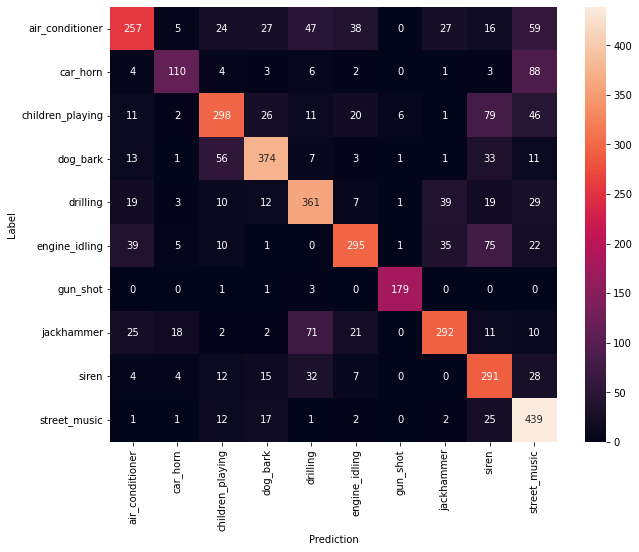

In [ ]:
import seaborn as sns
categories = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=categories,
            yticklabels=categories,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

###Overall testing

In [ ]:
result= []
for BATCH_SIZE in [32,64,128]:  
  for EPOCHS in [30,40,50,70]:
    for i in range(3):
      mel_model = create_mfcc_model(input_shape)

      mel_model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True),
      metrics=['accuracy'],
      )

      history = mel_model.fit(
      mel_x_train,
      mel_y_train,
      epochs=EPOCHS,
      batch_size=BATCH_SIZE
      )

      test_loss, test_acc = mel_model.evaluate(mel_x_test, mel_y_test, verbose = 1)

      test_loss_5, test_acc_5 = mel_model.evaluate(mel_x_test_5, mel_y_test_5, verbose = 1)

      test_loss_7, test_acc_7 = mel_model.evaluate(mel_x_test_7, mel_y_test_7, verbose = 1)

      test_loss_8, test_acc_8 = mel_model.evaluate(mel_x_test_8, mel_y_test_8, verbose = 1)

      test_loss_9, test_acc_9 = mel_model.evaluate(mel_x_test_9, mel_y_test_9, verbose = 1)

      test_loss_10, test_acc_10 = mel_model.evaluate(mel_x_test_10, mel_y_test_10, verbose = 1)

      average_accuracy = sum([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10])/5
      accuracy_std = np.std(np.array([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10]))

      result.append("Batch size: "+ str(BATCH_SIZE) + " Epoche: "+ str(EPOCHS) + " Train acc: "+ str(history.history['accuracy'][-1])+ " Test acc: "+ str(average_accuracy) + " Test accuracy Std:" + str(accuracy_std))

In [ ]:
f=open('mel_results.txt','w')
for ele in result:
    f.write(ele+'\n')

f.close()

##CNN MFCC with validation


Class distribution of the samples for each fold

In [ ]:
stats = pd.read_csv("/content/statistics.csv")
for i in [1,2,3,4,6]:
  print("Fold: "+str(i))
  print(stats['class'][stats['fold']==i].value_counts(normalize = True).sort_index())

Fold: 1
0    0.114548
1    0.041237
2    0.114548
3    0.114548
4    0.114548
5    0.109966
6    0.040092
7    0.137457
8    0.098511
9    0.114548
Name: class, dtype: float64
Fold: 2
0    0.112613
1    0.047297
2    0.112613
3    0.112613
4    0.112613
5    0.112613
6    0.039414
7    0.135135
8    0.102477
9    0.112613
Name: class, dtype: float64
Fold: 3
0    0.108108
1    0.046486
2    0.108108
3    0.108108
4    0.108108
5    0.115676
6    0.038919
7    0.129730
8    0.128649
9    0.108108
Name: class, dtype: float64
Fold: 4
0    0.101010
1    0.059596
2    0.101010
3    0.101010
4    0.101010
5    0.108081
6    0.038384
7    0.121212
8    0.167677
9    0.101010
Name: class, dtype: float64
Fold: 6
0    0.121507
1    0.034022
2    0.121507
3    0.121507
4    0.121507
5    0.130012
6    0.055893
7    0.082625
8    0.089915
9    0.121507
Name: class, dtype: float64


In [ ]:
x_train_1 = []
x_train_2 = []
x_train_3 = []
x_train_4 = []
x_train_6 = []

y_train_1 = []
y_train_2 = []
y_train_3 = []
y_train_4 = []
y_train_6 = []

x_test = []
y_test = []

x_test_5 = []
x_test_7 = []
x_test_8 = []
x_test_9 = []
x_test_10 = []

y_test_5 = []
y_test_7 = []
y_test_8 = []
y_test_9 = []
y_test_10 = []


for dir in os.listdir("/content/UrbanSoundPreprocessed/"):
  if(dir!='.DS_Store'):
    for file in os.listdir("/content/UrbanSoundPreprocessed/"+dir+"/"):
      if(file!='.DS_Store'):
        file_path = "./UrbanSoundPreprocessed/"+dir+"/"+file
        sound_file, sampling_rate = librosa.load(file_path, sr = None)
        category = float(file.split('-')[1])
        
        mfcc = librosa.feature.mfcc(y=sound_file, sr=sampling_rate, n_mfcc=40)
        
        if ((dir == 'fold1') | (dir == 'fold2') | (dir == 'fold3') | (dir == 'fold4') | (dir == 'fold6')):
        
          if(dir == 'fold1'):
            x_train_1.append(mfcc)
            y_train_1.append(category)
          if(dir == 'fold2'):
            x_train_2.append(mfcc)
            y_train_2.append(category)
          if(dir == 'fold3'):
            x_train_3.append(mfcc)
            y_train_3.append(category)
          if(dir == 'fold4'):
            x_train_4.append(mfcc)
            y_train_4.append(category)
          if(dir == 'fold6'):
            x_train_6.append(mfcc)
            y_train_6.append(category)

        else:
          x_test.append(mfcc)
          y_test.append(category)

          if (dir == 'fold5'):
            x_test_5.append(mfcc)
            y_test_5.append(category)
          
          if (dir == 'fold7'):
            x_test_7.append(mfcc)
            y_test_7.append(category)

          if (dir == 'fold8'):
            x_test_8.append(mfcc)
            y_test_8.append(category)
          
          if (dir == 'fold9'):
            x_test_9.append(mfcc)
            y_test_9.append(category)
          
          if (dir == 'fold10'):
            x_test_10.append(mfcc)
            y_test_10.append(category)

In [ ]:
mfcc_x_train_1 = np.array(x_train_1)
mfcc_x_train_2 = np.array(x_train_2)
mfcc_x_train_3 = np.array(x_train_3)
mfcc_x_train_4 = np.array(x_train_4)
mfcc_x_train_6 = np.array(x_train_6)

mfcc_y_train_1 = np.array(y_train_1)
mfcc_y_train_2 = np.array(y_train_2)
mfcc_y_train_3 = np.array(y_train_3)
mfcc_y_train_4 = np.array(y_train_4)
mfcc_y_train_6 = np.array(y_train_6)

mfcc_x_test = np.array(x_test)
mfcc_x_test_5 = np.array(x_test_5)
mfcc_x_test_7 = np.array(x_test_7)
mfcc_x_test_8 = np.array(x_test_8)
mfcc_x_test_9 = np.array(x_test_9)
mfcc_x_test_10 = np.array(x_test_10)

mfcc_y_test_5 = np.array(y_test_5)
mfcc_y_test_7 = np.array(y_test_7)
mfcc_y_test_8 = np.array(y_test_8)
mfcc_y_test_9 = np.array(y_test_9)
mfcc_y_test_10 = np.array(y_test_10)

mfcc_y_test = np.array(y_test)

In [ ]:
mfcc_x_train = np.array([])
mfcc_y_train = np.array([])
val_x = np.array([])
val_y = np.array([])
best_validation_accuracy = 0
train_x_list = [mfcc_x_train_1,mfcc_x_train_2,mfcc_x_train_3,mfcc_x_train_4,mfcc_x_train_6]
train_y_list = [mfcc_y_train_1,mfcc_y_train_2,mfcc_y_train_3,mfcc_y_train_4,mfcc_y_train_6]

for i in range(5):
  for j in range(5):
    if(i!=j):
      if mfcc_x_train.size != 0:
        mfcc_x_train = np.append(mfcc_x_train,train_x_list[j],axis=0)
        mfcc_y_train = np.append(mfcc_y_train,train_y_list[j])
      else:
        mfcc_x_train = train_x_list[j]
        mfcc_y_train = train_y_list[j]
    else:
        val_x = train_x_list[j]
        val_y = train_y_list[j]

  mfcc_x_train = mfcc_x_train.reshape(mfcc_x_train.shape[0], len(mfcc_x_train[0]), len(mfcc_x_train[0][0]),1)

  input_shape = mfcc_x_train.shape[1:]

  mfcc_y_train = np.array(mfcc_y_train)
  val_x = np.array(val_x)
  val_y = np.array(val_y)

  model = create_mfcc_model(input_shape)

  model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
  #model.summary()

  print('Model '+str(i)+':')

  EPOCHS = 30

  BATCH_SIZE = 32

  history = model.fit(
    mfcc_x_train,
    mfcc_y_train,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = (val_x,val_y),
    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)
  )
  
  if (history.history['val_accuracy'][-1] > best_validation_accuracy):
    best_validation_accuracy = history.history['val_accuracy'][-1]
    best_model = model

  mfcc_x_train = np.array([])
  mfcc_y_train = np.array([])

In [ ]:
# Evaluating the model on the training and testing set
print("Testing on all test folds")
test_loss, test_acc = best_model.evaluate(mfcc_x_test, mfcc_y_test, verbose = 1)

print("Testing on each test fold singularly")
test_loss_5, test_acc_5 = best_model.evaluate(mfcc_x_test_5, mfcc_y_test_5, verbose = 1)

test_loss_7, test_acc_7 = best_model.evaluate(mfcc_x_test_7, mfcc_y_test_7, verbose = 1)

test_loss_8, test_acc_8 = best_model.evaluate(mfcc_x_test_8, mfcc_y_test_8, verbose = 1)

test_loss_9, test_acc_9 = best_model.evaluate(mfcc_x_test_9, mfcc_y_test_9, verbose = 1)

test_loss_10, test_acc_10 = best_model.evaluate(mfcc_x_test_10, mfcc_y_test_10, verbose = 1)

average_accuracy = sum([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10])/5
accuracy_std = np.std(np.array([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10]))

print("Average test Accuracy:" + str(average_accuracy))
print("Average accuracy Std:" + str(accuracy_std))

Testing on all test folds
133/133 [==============================] - 1s 9ms/step - loss: 1.5377 - accuracy: 0.5223
Testing on each test fold singularly
27/27 [==============================] - 0s 11ms/step - loss: 1.6452 - accuracy: 0.4839
Average test Accuracy:0.5237010836601257
Average accuracy Std:0.04440853427253379


In [ ]:
y_pred = np.argmax(best_model.predict(mfcc_x_test), axis=1)
y_pred_2 = np.argsort(best_model.predict(mfcc_x_test), axis=1)[:,-2]
y_true = mfcc_y_test

test_acc = (sum(y_pred == y_true) + sum(y_pred_2 == y_true))/ len(y_true)
print(f'Top 2 classes test set accuracy: {test_acc:.0%}')

Top 2 classes test set accuracy: 72%


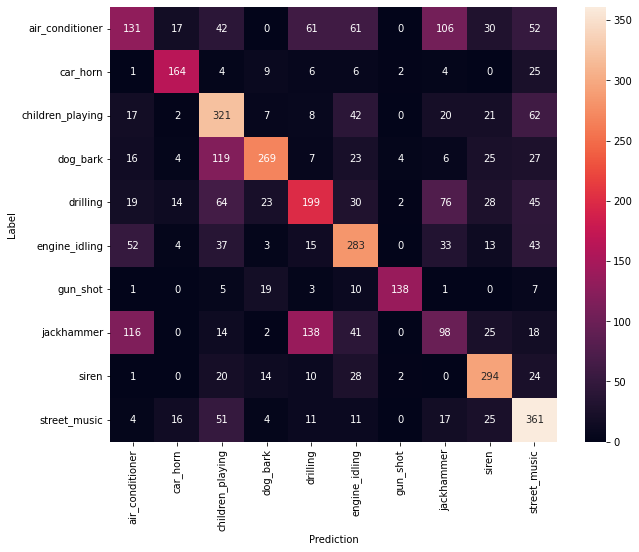

In [ ]:
import seaborn as sns
categories = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=categories,
            yticklabels=categories,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

##CNN MFCC without validation

In [31]:
x_train = []
x_test = []
y_train = []
y_test = []

x_test_5 = []
x_test_7 = []
x_test_8 = []
x_test_9 = []
x_test_10 = []

y_test_5 = []
y_test_7 = []
y_test_8 = []
y_test_9 = []
y_test_10 = []


for dir in os.listdir("/content/UrbanSoundPreprocessed/"):
  if(dir!='.DS_Store'):
    for file in os.listdir("/content/UrbanSoundPreprocessed/"+dir+"/"):
      if(file!='.DS_Store'):
        file_path = "./UrbanSoundPreprocessed/"+dir+"/"+file
        sound_file, sampling_rate = librosa.load(file_path, sr = None)
        category = float(file.split('-')[1])

        mfcc = librosa.feature.mfcc(y=sound_file, sr=sampling_rate, n_mfcc=40)
        
        if ((dir == 'fold1') | (dir == 'fold2') | (dir == 'fold3') | (dir == 'fold4') | (dir == 'fold6')):
          x_train.append(mfcc)
          y_train.append(category)

        else:   
          x_test.append(mfcc)
          y_test.append(category)
          
          if (dir == 'fold5'):
            x_test_5.append(mfcc)
            y_test_5.append(category)
          
          if (dir == 'fold7'):
            x_test_7.append(mfcc)
            y_test_7.append(category)

          if (dir == 'fold8'):
            x_test_8.append(mfcc)
            y_test_8.append(category)
          
          if (dir == 'fold9'):
            x_test_9.append(mfcc)
            y_test_9.append(category)
          
          if (dir == 'fold10'):
            x_test_10.append(mfcc)
            y_test_10.append(category)


In [32]:
mfcc_x_train = np.array(x_train)
mfcc_x_train = mfcc_x_train.reshape(mfcc_x_train.shape[0], len(mfcc_x_train[0]), len(mfcc_x_train[0][0]),1)

mfcc_y_train = np.array(y_train)

mfcc_x_test = np.array(x_test)
mfcc_x_test_5 = np.array(x_test_5)
mfcc_x_test_7 = np.array(x_test_7)
mfcc_x_test_8 = np.array(x_test_8)
mfcc_x_test_9 = np.array(x_test_9)
mfcc_x_test_10 = np.array(x_test_10)

mfcc_y_test_5 = np.array(y_test_5)
mfcc_y_test_7 = np.array(y_test_7)
mfcc_y_test_8 = np.array(y_test_8)
mfcc_y_test_9 = np.array(y_test_9)
mfcc_y_test_10 = np.array(y_test_10)

mfcc_y_test = np.array(y_test)

In [33]:
input_shape = mfcc_x_train.shape[1:]
input_shape

(40, 348, 1)

In [34]:
# Construct model 
mfcc_model = create_mfcc_model(input_shape)

In [35]:
# Compile the model
mfcc_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
mfcc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 36, 344, 16)       416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 172, 16)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 18, 172, 16)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 169, 32)       8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 84, 32)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 84, 32)        

In [ ]:
EPOCHS = 70
BATCH_SIZE = 128

history = mfcc_model.fit(
    mfcc_x_train,
    mfcc_y_train,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE
)

In [ ]:
# Evaluating the model on the training and testing set
score = mfcc_model.evaluate(mfcc_x_train, mfcc_y_train, verbose=0)
print("Training Accuracy: ", score[1])

test_loss, test_acc = mfcc_model.evaluate(mfcc_x_test, mfcc_y_test, verbose = 1)

test_loss_5, test_acc_5 = mfcc_model.evaluate(mfcc_x_test_5, mfcc_y_test_5, verbose = 1)

test_loss_7, test_acc_7 = mfcc_model.evaluate(mfcc_x_test_7, mfcc_y_test_7, verbose = 1)

test_loss_8, test_acc_8 = mfcc_model.evaluate(mfcc_x_test_8, mfcc_y_test_8, verbose = 1)

test_loss_9, test_acc_9 = mfcc_model.evaluate(mfcc_x_test_9, mfcc_y_test_9, verbose = 1)

test_loss_10, test_acc_10 = mfcc_model.evaluate(mfcc_x_test_10, mfcc_y_test_10, verbose = 1)

average_accuracy = sum([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10])/5
accuracy_std = np.std(np.array([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10]))

print("Test Accuracy:" + str(average_accuracy))
print("Accuracy Std:" + str(accuracy_std))

In [ ]:
y_pred = np.argmax(mfcc_model.predict(mfcc_x_test), axis=1)
y_pred_2 = np.argsort(mfcc_model.predict(mfcc_x_test), axis=1)[:,-2]
y_true = mfcc_y_test

test_acc = (sum(y_pred == y_true) + sum(y_pred_2 == y_true))/ len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

In [ ]:
import seaborn as sns
categories = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=categories,
            yticklabels=categories,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


##Chromagram


In [ ]:
x_train = []
y_train = []

x_test = []
y_test = []

x_test_5 = []
x_test_7 = []
x_test_8 = []
x_test_9 = []
x_test_10 = []

y_test_5 = []
y_test_7 = []
y_test_8 = []
y_test_9 = []
y_test_10 = []

for dir in os.listdir("/content/UrbanSoundPreprocessed/"):
  if(dir!='.DS_Store'):
    for file in os.listdir("/content/UrbanSoundPreprocessed/"+dir+"/"):
      if(file!='.DS_Store'):
        file_path = "./UrbanSoundPreprocessed/"+dir+"/"+file
        sound_file, sampling_rate = librosa.load(file_path, sr = None)
        category = float(file.split('-')[1])
        
        chroma = librosa.feature.chroma_stft(y=sound_file, sr=sampling_rate, hop_length=1024, win_length=2048)
        
        if ((dir == 'fold1') | (dir == 'fold2') | (dir == 'fold3') | (dir == 'fold4') | (dir == 'fold6')):
          x_train.append(chroma)
          y_train.append(category)
          
        else:
          x_test.append(chroma)
          y_test.append(category)

          if (dir == 'fold5'):
            x_test_5.append(chroma)
            y_test_5.append(category)
          
          if (dir == 'fold7'):
            x_test_7.append(chroma)
            y_test_7.append(category)

          if (dir == 'fold8'):
            x_test_8.append(chroma)
            y_test_8.append(category)
          
          if (dir == 'fold9'):
            x_test_9.append(chroma)
            y_test_9.append(category)
          
          if (dir == 'fold10'):
            x_test_10.append(chroma)
            y_test_10.append(category)

chroma_x_train = np.array(x_train)
chroma_x_train = chroma_x_train.reshape(chroma_x_train.shape[0], len(chroma_x_train[0]), len(chroma_x_train[0][0]),1)

chroma_y_train = np.array(y_train)

chroma_x_test = np.array(x_test)
chroma_x_test_5 = np.array(x_test_5)
chroma_x_test_7 = np.array(x_test_7)
chroma_x_test_8 = np.array(x_test_8)
chroma_x_test_9 = np.array(x_test_9)
chroma_x_test_10 = np.array(x_test_10)

chroma_y_test_5 = np.array(y_test_5)
chroma_y_test_7 = np.array(y_test_7)
chroma_y_test_8 = np.array(y_test_8)
chroma_y_test_9 = np.array(y_test_9)
chroma_y_test_10 = np.array(y_test_10)

chroma_y_test = np.array(y_test)

In [ ]:
input_shape = chroma_x_train.shape[1:]
input_shape

(12, 174, 1)

In [ ]:
chroma_model = create_chroma_model(input_shape) 

In [ ]:
# Compile the model
chroma_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
# Display model architecture summary 
chroma_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 11, 173, 128)      640       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 5, 86, 128)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 5, 86, 128)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 4, 85, 256)        131328    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 2, 42, 256)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 2, 42, 256)       

In [ ]:
EPOCHS = 50
BATCH_SIZE = 32

history = chroma_model.fit(
    chroma_x_train,
    chroma_y_train,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
)

In [ ]:
# Evaluating the model on the training and testing set
score = chroma_model.evaluate(chroma_x_train, chroma_y_train, verbose=0)
print("Training Accuracy: ", score[1])

test_loss, test_acc = chroma_model.evaluate(chroma_x_test, chroma_y_test, verbose = 1)

test_loss_5, test_acc_5 = chroma_model.evaluate(chroma_x_test_5, chroma_y_test_5, verbose = 1)

test_loss_7, test_acc_7 = chroma_model.evaluate(chroma_x_test_7, chroma_y_test_7, verbose = 1)

test_loss_8, test_acc_8 = chroma_model.evaluate(chroma_x_test_8, chroma_y_test_8, verbose = 1)

test_loss_9, test_acc_9 = chroma_model.evaluate(chroma_x_test_9, chroma_y_test_9, verbose = 1)

test_loss_10, test_acc_10 = chroma_model.evaluate(chroma_x_test_10, chroma_y_test_10, verbose = 1)

average_accuracy = sum([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10])/5
accuracy_std = np.std(np.array([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10]))

print("Test Accuracy:" + str(average_accuracy))
print("Accuracy Std:" + str(accuracy_std))

Training Accuracy:  0.6474772095680237
27/27 [==============================] - 0s 8ms/step - loss: 1.3023 - accuracy: 0.5269
Test Accuracy:0.5226522326469422
Accuracy Std:0.023028981367268497


In [ ]:
y_pred = np.argmax(chroma_model.predict(chroma_x_test), axis=1)
y_pred_2 = np.argsort(chroma_model.predict(chroma_x_test), axis=1)[:,-2]
y_true = chroma_y_test

test_acc = (sum(y_pred == y_true) + sum(y_pred_2 == y_true))/ len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 73%


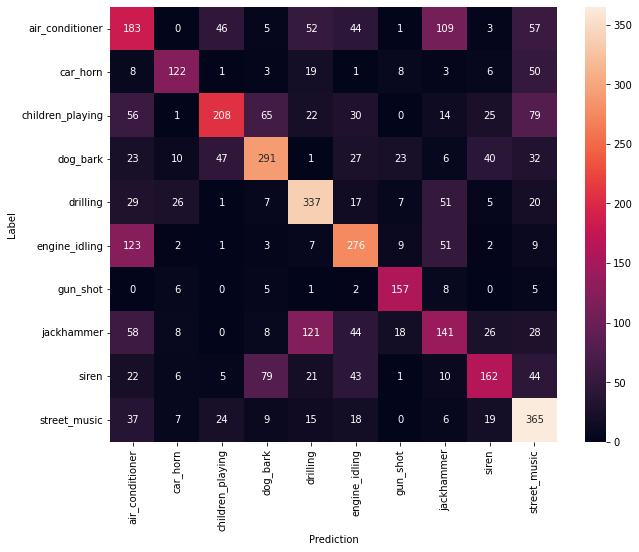

In [ ]:
import seaborn as sns
categories = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=categories,
            yticklabels=categories,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

###Overall testing

In [ ]:
result= []
for BATCH_SIZE in [32,64,128]:  
  for EPOCHS in [30,40,50,70]:
    for i in range(3):
      chroma_model = create_chroma_model(input_shape) 
      
      chroma_model.compile(
          loss='sparse_categorical_crossentropy', 
          metrics=['accuracy'], 
          optimizer='adam'
      )
      
      history = chroma_model.fit(
          chroma_x_train, 
          chroma_y_train, 
          epochs=EPOCHS,
          batch_size = BATCH_SIZE
      )

      test_loss, test_acc = chroma_model.evaluate(chroma_x_test, chroma_y_test, verbose = 1)

      test_loss_5, test_acc_5 = chroma_model.evaluate(chroma_x_test_5, chroma_y_test_5, verbose = 1)

      test_loss_7, test_acc_7 = chroma_model.evaluate(chroma_x_test_7, chroma_y_test_7, verbose = 1)

      test_loss_8, test_acc_8 = chroma_model.evaluate(chroma_x_test_8, chroma_y_test_8, verbose = 1)

      test_loss_9, test_acc_9 = chroma_model.evaluate(chroma_x_test_9, chroma_y_test_9, verbose = 1)

      test_loss_10, test_acc_10 = chroma_model.evaluate(chroma_x_test_10, chroma_y_test_10, verbose = 1)

      average_accuracy = sum([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10])/5
      accuracy_std = np.std(np.array([test_acc_5,test_acc_7,test_acc_8,test_acc_9,test_acc_10]))

      result.append("Batch size: "+ str(BATCH_SIZE) + " Epoche: "+ str(EPOCHS) + " Train acc: "+ str(history.history['accuracy'][-1])+ " Test acc: "+ str(average_accuracy) + " Test accuracy Std:" + str(accuracy_std))

In [ ]:
f=open('chroma_results.txt','w')
for ele in result:
    f.write(ele+'\n')

f.close()

In [ ]:
from google.colab import files
files.download('chroma_results.txt')